<a href="https://colab.research.google.com/github/Vrushali-M/Fall_2019_ML_project/blob/master/ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#root_path = r'/gdrive/My Drive/ML_proje4/twFt1dvB4mxpoqFfbiStykZCIbIo-O-II0mn2ZXLqVlyaRZ6keiLPhUct/'  #change dir to project folder
#drive.mount(root_path)
#ValueError: Mountpoint must not contain a space. 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Run Once only 
#!mkdir 'gdrive/My Drive/ML_project/data'

#!unzip 'gdrive/My Drive/ML_project/ieee-fraud-detection.zip'  -d 'gdrive/My Drive/ML_project/data'

In [2]:
!ls 'gdrive/My Drive/ML_project/data'

ml_2k_train_identity.csv     test_identity.csv	   train_identity.html
ml_2k_train_transaction.csv  test_transaction.csv  train_transaction.csv
sample_submission.csv	     train_identity.csv


In [0]:
data_path = r'gdrive/My Drive/ML_project/data'

PreProcessing


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
import pandas_profiling
import os

%matplotlib inline
%tensorflow_version 1.x

Load Data


In [0]:
path1 = os.path.join(data_path, 'train_transaction.csv')
path2 = os.path.join(data_path, 'train_identity.csv')

In [0]:

#!chmod 777 -R 'gdrive/My Drive/ML_project/data'

In [8]:
train_transaction = pd.read_csv(path1, engine='python')
train_identity = pd.read_csv(path2, engine='python')
print('Train data set is loaded')

Train data set is loaded


In [0]:
train_transactions = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [10]:
print(list(train_transactions.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

In [0]:
## droping columns
col_list = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

for col in col_list:

  train_transactions.drop(col, axis = 1,inplace=True)

Data Insights


In [12]:
train_transactions.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mobile,SAMSUNG SM-G892A Build/NRD90M


In [13]:
train_transactions.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,...,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,...,0.045507,0.052002,0.251761,0.283140,0.264208,1.000007,139.748713,408.682375,230.413180,10.995986,118.195658,4.202175,39.173910,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,...,0.289573,0.318310,0.481889,0.623608,0.528238,0.002603,2348.849634,4391.992977,3021.924247,116.254277,352.983093,102.374938,172.128339,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,-83.000000,0.000000,-193.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.

In [0]:
## Run only once

#from pandas_profiling import ProfileReport

#profile_train_trans = ProfileReport(train_transactions)
#profile_train_trans.to_file(data_path+"/train_transactions.html")

In [0]:
### Imputation of missing values

In [0]:
def sizeDown(df,cols, type2):
    for l in cols:
        df[l] = np.round(pd.to_numeric(df[l], downcast= type2), 5)
    return df

In [0]:
def get_columns_by_group(df):
    """Returns the number of types and dictionary of with values dataframes and key as type"""
    column_types = df.columns.to_series().groupby(df.dtypes).groups
    k = list(column_types.keys())
    list_df = {}
    for i in k:
        list_df[i] = (df[column_types[i]])
    return list_df, k

In [0]:
def downsize_numericals(df):
    column_types = df.columns.to_series().groupby(df.dtypes).groups
    k = list(column_types.keys())
    for i in k:
        if str(i) == 'float64':
            df[column_types[i]] = sizeDown(df[column_types[i]], column_types[i], "float")
        elif str(i) == 'int64':
            df[column_types[i]] = sizeDown(df[column_types[i]], column_types[i], "integer")
        else:
            pass
    return df

In [20]:
train_transactions = downsize_numericals(train_transactions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
train_transactions_info = get_columns_by_group(train_transactions)

In [22]:
train_transactions_info[1]

[dtype('int8'), dtype('int16'), dtype('int32'), dtype('float32'), dtype('O')]

In [0]:
int8_cols = train_transactions_info[0][train_transactions_info[1][0]]
int16_cols = train_transactions_info[0][train_transactions_info[1][1]]
int32_cols = train_transactions_info[0][train_transactions_info[1][2]]
float32_cols = train_transactions_info[0][train_transactions_info[1][3]]
char_cols = train_transactions_info[0][train_transactions_info[1][4]]

In [24]:
int8_cols.isna().sum()


isFraud    0
dtype: int64

In [25]:
int16_cols.isna().sum()

## No missing

card1    0
dtype: int64

In [26]:
int32_cols.isna().sum()


## no missing

TransactionID    0
TransactionDT    0
dtype: int64

In [27]:
float32_cols.isna().sum()

TransactionAmt         0
card2               8933
card3               1565
card5               4259
addr1              65706
                   ...  
V335              508189
V336              508189
V337              508189
V338              508189
V339              508189
Length: 376, dtype: int64

In [28]:
char_cols.head()

## needs to be encoded first

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [0]:
### Label Encoding

In [0]:
## Label Encode

def labelencode_column(column_list, df):
    from sklearn import preprocessing

    for column in column_list:
            email_domain_dict = {}
            current_num = 0
            temp_col = df[column].dropna()
            for val in temp_col:                
                if val in email_domain_dict.keys():
                    pass
                else:
                    email_domain_dict[val]= current_num
                    current_num+=1    
            df[column] = df[column].map(email_domain_dict) 
    return df

#column_list = ['card4', 'ProductCD', 'card6', 'P_emaildomain', 'R_emaildomain']
# To call use this
#labelencode_columns(column_list, df)

In [30]:
char_col = labelencode_column(char_cols.columns, char_cols)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [31]:
char_col.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2,0,2.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN
3,0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [32]:
## preprocessing the numerical columns
temp = pd.concat([float32_cols, char_cols], axis=1)
temp.head()

,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,68.5,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,1.0,1.0,1.0,...,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,29.0,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN
2,59.0,490.0,150.0,166.0,330.0,87.0,287.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN
3,50.0,567.0,150.0,117.0,476.0,87.0,NaN,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,...,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,50.0,514.0,150.0,102.0,420.0,87.0,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [33]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=5, verbose=1, n_nearest_features=6)
temp_df = imp.fit_transform(temp)
temp_df = pd.DataFrame(temp_df, columns=temp.columns)

[IterativeImputer] Completing matrix with shape (590540, 392)


/usr/local/lib/python3.6/dist-packages/sklearn/impute/_iterative.py:603: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [34]:
df = pd.concat([int8_cols, int32_cols, int16_cols, temp_df], axis=1)
df.head()

,isFraud,TransactionID,TransactionDT,card1,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo
0,0,2987000,86400,13926,68.5,353.569889,150.0,142.0,315.0,87.0,19.000000,221.408591,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,54.811114,13.000000,155.917532,40.183225,67.036059,48.906502,166.000361,0.612498,13.000000,13.000000,164.447411,8.915615,48.765295,...,0.0,117.0,0.0,0.0,0.0,0.0,0.216783,0.200565,0.406656,-0.059187,0.469392,0.045076,0.024505,0.035404,0.257446,138.377415,193.949169,59.579810,-0.717545,-60.066000,-8.546150,21.430034,22.190423,57.908770,0.0,0.0,0.0,3.461292,4.045609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122965,0.356301,0.825497,0.679888,102.318385
1,0,2987001,86401,2755,29.0,404.000000,150.0,102.0,325.0,87.0,130.803673,213.715567,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,54.054222,14.298888,0.000000,57.941848,67.159302,48.798182,168.085115,0.586906,0.000000,-14.048360,164.281425,10.069390,48.458326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.295937,0.123063,0.535451,-0.059378,0.585663,0.044518,0.024534,0.036391,0.227728,165.012626,99.924648,14.456189,-1.164532,20.570352,-8.456137,30.414957,34.945570,79.832636,0.0,1.0,0.0,0.000000,4.047357,0.000029,0.106572,0.197962,1.000000,1.000000,0.000000,0.128389,0.349180,0.818900,0.680088,102.110234
2,0,2987002,86469,4663,59.0,490.000000,150.0,166.0,330.0,87.0,287.000000,222.471414,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,219.973734,4.013444,0.000000,40.026173,67.133414,48.893612,166.077548,0.621546,0.000000,315.000000,164.217649,79.534701,48.596225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.212991,0.152855,0.544011,-0.058183,0.588981,0.040386,0.024534,0.035964,0.211202,97.017538,105.699399,29.036437,-0.087417,-60.099531,-8.442078,24.379996,26.727541,79.388120,0.0,2.0,1.0,1.000000,4.047602,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.679965,102.159392
3,0,2987003,86499,18132,50.0,567.000000,150.0,117.0,476.0,87.0,128.978340,197.664003,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,64.380796,49.171095,163.359772,0.615445,84.000000,106.617202,166.450954,33.712459,51.352979,...,50.0,1404.0,790.0,0.0,0.0,0.0,1.634601,38.587704,25.009571,-0.091187,0.277108,3.083748,0.025432,0.005986,1.189039,-1003.991328,3111.312738,2324.421510,41.694857,108.289495,66.314267,-24.541203,-325.542397,-316.498039,0.0,1.0,1.0,2.000000,4.065868,0.000017,0.113026,0.471299,1.000000,1.000000,1.000000,0.122775,0.360936,0.818482,0.687513,35.998392
4,0,2987004,86506,4497,50.0,514.000000,150.0,102.0,420.0,87.0,134.300744,248.022510,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,212.805883,4.423293,135.642724,46.940754,67.495583,52.461453,176.039593,0.589496,120.783534,170.048144,391.874705,72.379316,92.444495,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,3.830977,0.000059,0.103915,0.208925,0.944338,0.424612,0.556244,0.171564,0.372011,0.831043,0.000000,0.000000


In [0]:
def create_unique_id(df):
    # Bank type
    df['bank_type'] = df['card3'].astype(str)+df['card5'].astype(str)

    # Full address
    df['full_addr'] = df['addr1'].astype(str)+df['addr2'].astype(str)

    # Virtual client uid
    i_cols = ['card1','card2','card3','card4','card5','card6', 'P_emaildomain', 'D1']
    df['uid1'] = ''
    for col in i_cols:
        df['uid1'] += df[col].astype(str)

    # Virtual client uid + full_addr
    df['uid2'] = df['uid1']+df['full_addr']
    return df

In [0]:
df = create_unique_id(df)

In [0]:
def add_fraud_card(df):    
    # fraud card column add with zeroes
    df['fraud_card']=0
    frauds = []
    
    for i in range (len(df)):
        if df['uid2'][i] in frauds:
            df['fraud_card'][i]=1
        if df['isFraud'][i] ==1:
            frauds.append(df['uid2'][i])
            df['fraud_card'][i]=1
            
    return df


In [38]:
df = add_fraud_card(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
df.head()

,isFraud,TransactionID,TransactionDT,card1,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,bank_type,full_addr,uid1,uid2,fraud_card
0,0,2987000,86400,13926,68.5,353.569889,150.0,142.0,315.0,87.0,19.000000,221.408591,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,54.811114,13.000000,155.917532,40.183225,67.036059,48.906502,166.000361,0.612498,13.000000,13.000000,164.447411,8.915615,48.765295,...,0.0,0.216783,0.200565,0.406656,-0.059187,0.469392,0.045076,0.024505,0.035404,0.257446,138.377415,193.949169,59.579810,-0.717545,-60.066000,-8.546150,21.430034,22.190423,57.908770,0.0,0.0,0.0,3.461292,4.045609,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122965,0.356301,0.825497,0.679888,102.318385,150.0142.0,315.087.0,13926353.56988886121593150.00.0142.00.03.46129...,13926353.56988886121593150.00.0142.00.03.46129...,0
1,0,2987001,86401,2755,29.0,404.000000,150.0,102.0,325.0,87.0,130.803673,213.715567,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,54.054222,14.298888,0.000000,57.941848,67.159302,48.798182,168.085115,0.586906,0.000000,-14.048360,164.281425,10.069390,48.458326,...,0.0,0.295937,0.123063,0.535451,-0.059378,0.585663,0.044518,0.024534,0.036391,0.227728,165.012626,99.924648,14.456189,-1.164532,20.570352,-8.456137,30.414957,34.945570,79.832636,0.0,1.0,0.0,0.000000,4.047357,0.000029,0.106572,0.197962,1.000000,1.000000,0.000000,0.128389,0.349180,0.818900,0.680088,102.110234,150.0102.0,325.087.0,2755404.0150.01.0102.00.00.00.0,2755404.0150.01.0102.00.00.00.0325.087.0,0
2,0,2987002,86469,4663,59.0,490.000000,150.0,166.0,330.0,87.0,287.000000,222.471414,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,219.973734,4.013444,0.000000,40.026173,67.133414,48.893612,166.077548,0.621546,0.000000,315.000000,164.217649,79.534701,48.596225,...,0.0,0.212991,0.152855,0.544011,-0.058183,0.588981,0.040386,0.024534,0.035964,0.211202,97.017538,105.699399,29.036437,-0.087417,-60.099531,-8.442078,24.379996,26.727541,79.388120,0.0,2.0,1.0,1.000000,4.047602,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.679965,102.159392,150.0166.0,330.087.0,4663490.0150.02.0166.01.01.00.0,4663490.0150.02.0166.01.01.00.0330.087.0,0
3,0,2987003,86499,18132,50.0,567.000000,150.0,117.0,476.0,87.0,128.978340,197.664003,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.000000,0.000000,64.380796,49.171095,163.359772,0.615445,84.000000,106.617202,166.450954,33.712459,51.352979,...,0.0,1.634601,38.587704,25.009571,-0.091187,0.277108,3.083748,0.025432,0.005986,1.189039,-1003.991328,3111.312738,2324.421510,41.694857,108.289495,66.314267,-24.541203,-325.542397,-316.498039,0.0,1.0,1.0,2.000000,4.065868,0.000017,0.113026,0.471299,1.000000,1.000000,1.000000,0.122775,0.360936,0.818482,0.687513,35.998392,150.0117.0,476.087.0,18132567.0150.01.0117.01.02.0112.0,18132567.0150.01.0117.01.02.0112.0476.087.0,0
4,0,2987004,86506,4497,50.0,514.000000,150.0,102.0,420.0,87.0,134.300744,248.022510,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,212.805883,4.423293,135.642724,46.940754,67.495583,52.461453,176.039593,0.589496,120.783534,170.048144,391.874705,72.379316,92.444495,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,3.830977,0.000059,0.103915,0.208925,0.944338,0.424612,0.556244,0.171564,0.372011,0.831043,0.000000,0.000000,150.0102.0,420.087.0,4497514.0150.01.0102.00.00.00.0,4497514.0150.01.0102.00.00.00.0420.087.0,0


In [0]:
df.to_csv(data_path+"/preprocessed_dataset.csv")

In [0]:
def multi_fraud_transactions_plot(sizes):
    import matplotlib.pyplot as plt
    %matplotlib inline

    # The slices will be ordered and plotted counter-clockwise.
    labels = 'cards with single fraud transaction', 'cards with multiple fraud transactions'
    colors = ['gold', 'lightcoral']
    explode = (0, 0.03)  # explode a slice if required

    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True)

    #draw a circle at the center of pie to make it look like a donut
    centre_circle = plt.Circle((0,0),0.75, fc='white',linewidth=1.25)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)


    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.show()  
    
#To USE
# multi_fraud_transactions_plot([30,70])

In [0]:
print(list(df.isna().sum()))

In [0]:
df.describe()

## PCA


In [53]:
print(list(df.iloc[:,395:].columns))

['DeviceInfo', 'bank_type', 'full_addr', 'uid1', 'uid2', 'fraud_card']


In [0]:
from sklearn.decomposition import PCA


# PCA C1 to C14
#df.iloc[:,12:26]
pca_C = PCA(n_components=1)
pComp_C = pca_C.fit_transform(df.iloc[:,12:26])


In [0]:
# PCA D1 to D15
#df.iloc[:,26:41]
pca_D = PCA(n_components=1)
pComp_D = pca_D.fit_transform(df.iloc[:,26:41])

In [0]:
# PCA V1 to V339
#df.iloc[:,41:380]
pca_V = PCA(n_components=1)
pComp_V = pca_V.fit_transform(df.iloc[:,41:380])

In [0]:
# PCA M1 to M9
#df.iloc[:,385:394]
pca_M = PCA(n_components=1)
pComp_M = pca_V.fit_transform(df.iloc[:,385:394])

In [52]:
pca_out_C = pd.DataFrame(data = pComp_C, columns = ['C'])
pca_out_D = pd.DataFrame(data = pComp_D, columns = ['D'])
pca_out_V = pd.DataFrame(data = pComp_V, columns = ['V'])
pca_out_M = pd.DataFrame(data = pComp_M, columns = ['M'])

print(pca_out_C.head())
print(pca_out_D.head())
print(pca_out_M.head())
print(pca_out_V.head())

           C
0 -33.729029
1 -34.036720
2 -34.026521
3 -23.142320
4 -33.449334
            D
0 -226.121402
1 -305.391176
2   52.965703
3  -69.028965
4   72.720236
          M
0  0.746621
1 -0.043132
2  0.015592
3  0.166057
4  0.059131
               V
0     418.774325
1    -410.949787
2    -350.062451
3    -502.020602
4  121804.740700


In [54]:
# a=pd.DataFrame(data = temp_df[:, 0:8])
# a
# pca_out_C.reset_index(drop=True, inplace=True)
# #pca_out_D.reset_index(drop=True, inplace=True)
# #pca_out_V.reset_index(drop=True, inplace=True)

pca_df = pd.concat([df.iloc[:, 0:12],df.iloc[:,380:385 ], df.iloc[:,394:], pca_out_C, pca_out_D, pca_out_V, pca_out_M], axis=1)
pca_df["R_emaildomain"] = np.round((pca_df["R_emaildomain"]), 0)
pca_df["P_emaildomain"] = np.round((pca_df["P_emaildomain"]), 0)
pca_df["DeviceType"] = np.round((pca_df["DeviceType"]), 0)
pca_df["DeviceInfo"] = np.round((pca_df["DeviceInfo"]), 0)

pca_df["ProductCD"] = np.round((pca_df["ProductCD"]), 0)
pca_df["card4"] = np.round((pca_df["card4"]), 0)
pca_df["card6"] = np.round((pca_df["card6"]), 0)
pca_df["M"] = np.round((pca_df["M"]), 0)

pca_df.head()

,isFraud,TransactionID,TransactionDT,card1,TransactionAmt,card2,card3,card5,addr1,addr2,dist1,dist2,ProductCD,card4,card6,P_emaildomain,R_emaildomain,DeviceType,DeviceInfo,bank_type,full_addr,uid1,uid2,fraud_card,C,D,V,M
0,0,2987000,86400,13926,68.5,353.569889,150.0,142.0,315.0,87.0,19.000000,221.408591,0.0,0.0,0.0,3.0,4.0,1.0,102.0,150.0142.0,315.087.0,13926353.56988886121593150.00.0142.00.03.46129...,13926353.56988886121593150.00.0142.00.03.46129...,0,-33.729029,-226.121402,418.774325,1.0
1,0,2987001,86401,2755,29.0,404.000000,150.0,102.0,325.0,87.0,130.803673,213.715567,0.0,1.0,0.0,0.0,4.0,1.0,102.0,150.0102.0,325.087.0,2755404.0150.01.0102.00.00.00.0,2755404.0150.01.0102.00.00.00.0325.087.0,0,-34.036720,-305.391176,-410.949787,-0.0
2,0,2987002,86469,4663,59.0,490.000000,150.0,166.0,330.0,87.0,287.000000,222.471414,0.0,2.0,1.0,1.0,4.0,1.0,102.0,150.0166.0,330.087.0,4663490.0150.02.0166.01.01.00.0,4663490.0150.02.0166.01.01.00.0330.087.0,0,-34.026521,52.965703,-350.062451,0.0
3,0,2987003,86499,18132,50.0,567.000000,150.0,117.0,476.0,87.0,128.978340,197.664003,0.0,1.0,1.0,2.0,4.0,1.0,36.0,150.0117.0,476.087.0,18132567.0150.01.0117.01.02.0112.0,18132567.0150.01.0117.01.02.0112.0476.087.0,0,-23.142320,-69.028965,-502.020602,0.0
4,0,2987004,86506,4497,50.0,514.000000,150.0,102.0,420.0,87.0,134.300744,248.022510,1.0,1.0,0.0,0.0,4.0,0.0,0.0,150.0102.0,420.087.0,4497514.0150.01.0102.00.00.00.0,4497514.0150.01.0102.00.00.00.0420.087.0,0,-33.449334,72.720236,121804.740700,0.0


In [59]:
pca_df["fraud_card"].value_counts()

0    537871
1     52669
Name: fraud_card, dtype: int64

In [55]:
pca_df = downsize_numericals(pca_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
pca_df.columns

Index(['isFraud', 'TransactionID', 'TransactionDT', 'card1', 'TransactionAmt',
       'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2',
       'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
       'DeviceType', 'DeviceInfo', 'bank_type', 'full_addr', 'uid1', 'uid2',
       'fraud_card', 'C', 'D', 'V', 'M'],
      dtype='object')

In [57]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 28 columns):
isFraud           590540 non-null int8
TransactionID     590540 non-null int32
TransactionDT     590540 non-null int32
card1             590540 non-null int16
TransactionAmt    590540 non-null float32
card2             590540 non-null float32
card3             590540 non-null float32
card5             590540 non-null float32
addr1             590540 non-null float32
addr2             590540 non-null float32
dist1             590540 non-null float32
dist2             590540 non-null float32
ProductCD         590540 non-null float32
card4             590540 non-null float32
card6             590540 non-null float32
P_emaildomain     590540 non-null float32
R_emaildomain     590540 non-null float32
DeviceType        590540 non-null float32
DeviceInfo        590540 non-null float32
bank_type         590540 non-null object
full_addr         590540 non-null object
uid1              

In [62]:
obj_cols = ["bank_type", "full_addr", "uid1", "uid2"]
pca_df[obj_cols] = labelencode_column(obj_cols, pca_df[obj_cols])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [63]:
obj_cols = ["bank_type", "full_addr", "uid1", "uid2"]
pca_df[obj_cols].head()

,bank_type,full_addr,uid1,uid2
0,0,0,0,0
1,1,1,1,1
2,2,2,2,2
3,3,3,3,3
4,1,4,4,4


In [64]:
# pca_df_reduced = pd.concat([temp_df.iloc[:, 0:8], pca_out_C/pca_out_C.max(), pca_out_D/pca_out_D.max(), pca_out_V/pca_out_V.max()], axis=1)
# pca_df_reduced
pca_df.columns

Index(['isFraud', 'TransactionID', 'TransactionDT', 'card1', 'TransactionAmt',
       'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2',
       'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
       'DeviceType', 'DeviceInfo', 'bank_type', 'full_addr', 'uid1', 'uid2',
       'fraud_card', 'C', 'D', 'V', 'M'],
      dtype='object')

In [0]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()
cols = [ 'card1', 'TransactionAmt', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2','fraud_card', 'C', 'D', 'V', 'M']
pca_df[cols] = scale.fit_transform(pca_df[cols])

In [70]:
pca_df = downsize_numericals(pca_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [71]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 28 columns):
isFraud           590540 non-null int8
TransactionID     590540 non-null int32
TransactionDT     590540 non-null int32
card1             590540 non-null float32
TransactionAmt    590540 non-null float32
card2             590540 non-null float32
card3             590540 non-null float32
card5             590540 non-null float32
addr1             590540 non-null float32
addr2             590540 non-null float32
dist1             590540 non-null float32
dist2             590540 non-null float32
ProductCD         590540 non-null float32
card4             590540 non-null float32
card6             590540 non-null float32
P_emaildomain     590540 non-null float32
R_emaildomain     590540 non-null float32
DeviceType        590540 non-null float32
DeviceInfo        590540 non-null float32
bank_type         590540 non-null int16
full_addr         590540 non-null int32
uid1              

In [0]:
pca_df.to_csv(data_path+"/df_after_csv.csv")

Features correlation



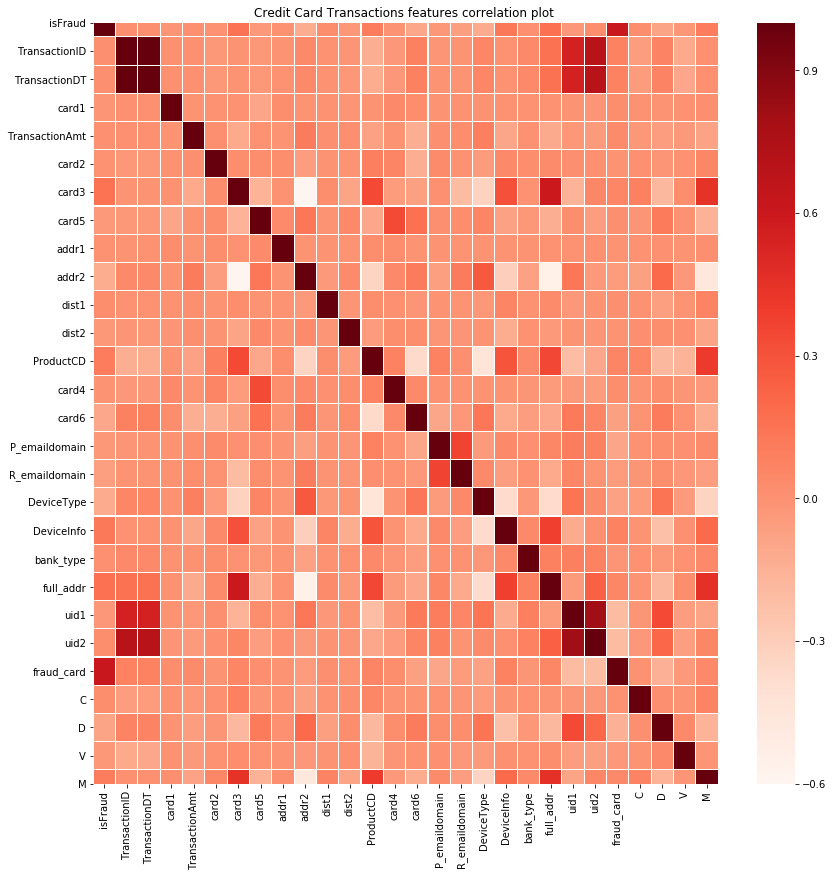

In [80]:
plt.figure(figsize = (14,14))
sns.heatmap(pca_df.corr(),xticklabels=pca_df.columns,yticklabels=pca_df.columns,linewidths=.1,cmap="Reds")
plt.title('Credit Card Transactions features correlation plot ')
plt.show()

isFraud Target Variable



Text(0.5, 1.0, 'isFraud Target variable count')

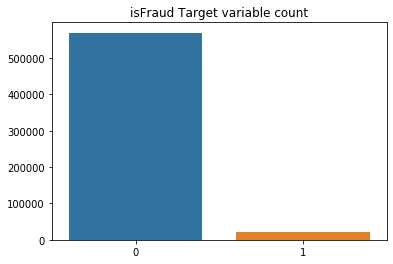

In [81]:
x=train_transactions['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('isFraud Target variable count')

There is imbalace problem.

In [86]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
def plot_2d_space(X_train, y_train,X=X,y=y ,label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    
    fig,(ax1,ax2)=plt.subplots(1,2, figsize=(8,4))
   
    for l, c, m in zip(np.unique(y), colors, markers):
        ax1.scatter(
            X_train[y_train==l, 0],
            X_train[y_train==l, 1],
            c=c, label=l, marker=m
        )
    for l, c, m in zip(np.unique(y), colors, markers):
        ax2.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
   
    ax1.set_title(label)
    ax2.set_title('original data')
    plt.legend(loc='upper right')
    plt.show()

In [89]:
pca_df.columns

Index(['isFraud', 'TransactionID', 'TransactionDT', 'card1', 'TransactionAmt',
       'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2',
       'ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain',
       'DeviceType', 'DeviceInfo', 'bank_type', 'full_addr', 'uid1', 'uid2',
       'fraud_card', 'C', 'D', 'V', 'M'],
      dtype='object')

In [0]:
X = pca_df.drop('isFraud', axis=1)
Y = pca_df['isFraud']

In [97]:
type(pca_df['isFraud'][0])

numpy.int8

In [0]:
smote = SMOTE(ratio='minority')
X_smote, Y_smote = smote.fit_sample(X, Y)


In [0]:
#plot_2d_space(X_smote, Y_smote,X,Y)

### Fit and predict on the data.



In [0]:
def logistic(X,y):
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=1)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)
    return (prob[:,1],y_test)


In [0]:
def plot_pre_curve(y_test,probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.')
    plt.title("precision recall curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the plot
    plt.show()
    

In [0]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [0]:
probs,y_test=logistic(X_sm,y_sm)
plot_pre_curve(y_test,probs)

In [0]:
plot_roc(y_test,probs)

Neural network 

In [0]:
!pip install tensorflow

In [0]:
from keras.models import Sequential
from keras.layers import Dense

classifier = Sequential()
classifier.add(Dense(units=200, activation = 'relu', input_dim = 376))
classifier.add(Dense(units=100, activation = 'relu'))
classifier.add(Dense(units=76, activation = 'relu'))
classifier.add(Dense(units=1, activation = 'sigmoid'))


In [0]:
classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy')

In [0]:
y= train_5000["isFraud"]

In [0]:
classifier.fit(temp_df,y, batch_size=1,epochs=2 )